## References
* [Skorch Transfer Learning](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/Transfer_Learning.ipynb)
* [Saving model pytorch](https://mc.ai/saving-loading-your-model-in-pytorch/)

ToDo: 
1. **Scheduler for both Pytorch and Skorch** - DONE
2. **Check work** - DONE
3. Check parameters for Skorch
4. Calculate accuracy for every class in PyTorch
5. **Calculate confusion matrix for Pytorch** - DONE
6. **Save models for PyTorch and Skorch** - DONE

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, confusion_matrix
from skorch.callbacks import Checkpoint, EpochScoring, LRScheduler
from skorch.classifier import NeuralNetClassifier
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set seed for reproducible result
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
# Download data
transform_ds = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform_ds)
test_ds = datasets.MNIST(root="data", train=False, download=True, transform=transform_ds)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

## Helper Function

In [3]:
# Get confusion matrix
def plot_confusion_matrix(y_pred, y_actual, figsize=(10, 8)):
    """Plot confusion matrix.
    """
    cm = confusion_matrix(y_pred, y_actual)
    cm_norm = cm
    #cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm_norm, interpolation='none', cmap='seismic', aspect='equal')
    ax.figure.colorbar(im, ax=ax, shrink=0.85)
    ax.set_title('Confusion matrix', fontsize=14)
    tick_marks = np.arange(10)
    #tick_marks = np.arange(len(encoder.categories_[0]))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    #ax.set_xticklabels(encoder.categories_[0], rotation=90)
    #ax.set_yticklabels(encoder.categories_[0])

    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        if cm_norm[i, j]!=0:
            ax.text(j, i, 
                    format(cm_norm[i, j], '.0f'),
                    horizontalalignment='center', verticalalignment='center', 
                    color='black' if (0.35 < cm_norm[i, j] < 0.65) else 'white',
                    fontsize=10,
                    fontweight=700)

    ax.set_xlabel('Predicted label', fontsize=14)
    ax.set_ylabel('Actual label', fontsize=14)
    ax.grid(linestyle=':')

## PyTorch separated train and test

In [4]:
# Create Neural Network
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2)
        self.drop = nn.Dropout2d(p=0.2)
        self.linear1 = nn.Linear(64*5*5, 64)
        self.linear2 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  # 32x26x26
        x = self.pool(x)  # 32x13x13
        x = self.drop(x)
        x = F.relu(self.conv2(x))  # 64x11x11
        x = self.pool(x)  # 64x5x5
        #x = x.view(-1, 64*5*5)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x       


def train(model, criterion, optimizer, data_loader, device):
    model.train()
    train_loss = 0
    train_accuracy = 0
    for samples, targets in data_loader:
        optimizer.zero_grad()
        samples, targets = samples.to(device), targets.to(device)
        output = model.forward(samples)
        loss = criterion(output, targets)
        train_loss += loss.item()
        train_accuracy += (torch.argmax(output, dim=1)==targets).sum().item()
        loss.backward()
        optimizer.step()
    else:
        train_loss /= len(data_loader.dataset)
        train_accuracy /= len(data_loader.dataset)
    
    return train_loss, train_accuracy


def test(model, criterion, data_loader, device):
    model.eval()
    test_loss = 0
    test_accuracy = 0
    with torch.no_grad():
        for samples, targets in data_loader:
            samples, targets = samples.to(device), targets.to(device)
            output = model.forward(samples)
            loss = criterion(output, targets)
            test_loss += loss.item()
            test_accuracy += (torch.argmax(output, dim=1)==targets).sum().item()
        else:
            test_loss /= len(data_loader.dataset)
            test_accuracy /= len(data_loader.dataset)
    
    return test_loss, test_accuracy


In [5]:
epochs = 5
min_loss = np.Inf
eps = 5e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvClassifier().to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)

for epoch in range(epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader, device)
    test_loss, test_acc = test(model, criterion, test_loader, device)
    scheduler.step()
    
    print(f"Epoch {epoch+1} | train loss: {train_loss:.5f} | train accuracy: {train_acc:.5f} | "
          f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.5f}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.7f}")

    if (min_loss - train_loss) > eps:
        print("Saving model...")
        torch.save({
            'model': ConvClassifier(),
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc
        }, 'model.pt')
        min_loss = train_loss


Epoch 1 | train loss: 0.17018 | train accuracy: 0.94922 | test loss: 0.05644 | test accuracy: 0.98170
Learning rate: 0.0008000
Saving model...


c:\users\se.vi.dmitriev\python-virtual-environments\pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\se.vi.dmitriev\python-virtual-environments\pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\se.vi.dmitriev\python-virtual-environments\pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\se.vi.dmitriev\python-virtual-environments\pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source co

Epoch 2 | train loss: 0.05249 | train accuracy: 0.98373 | test loss: 0.04579 | test accuracy: 0.98470
Learning rate: 0.0006400
Saving model...
Epoch 3 | train loss: 0.03635 | train accuracy: 0.98847 | test loss: 0.03131 | test accuracy: 0.98930
Learning rate: 0.0005120
Saving model...
Epoch 4 | train loss: 0.02544 | train accuracy: 0.99258 | test loss: 0.02886 | test accuracy: 0.98930
Learning rate: 0.0004096
Saving model...
Epoch 5 | train loss: 0.01901 | train accuracy: 0.99407 | test loss: 0.02665 | test accuracy: 0.99070
Learning rate: 0.0003277
Saving model...


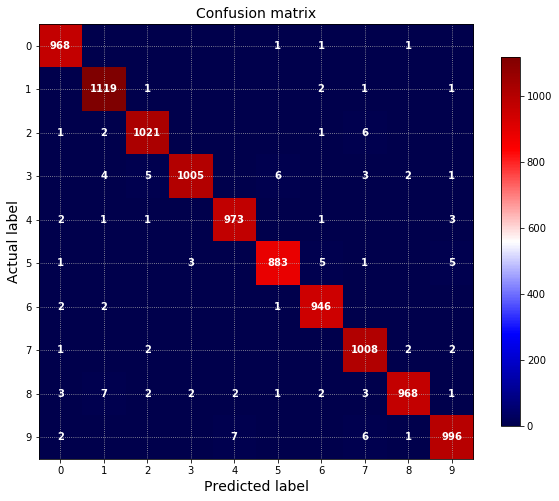

In [15]:
# Make predictions
model.eval()
device_cpu = torch.device("cpu")
N = 100000
result2 = torch.argmax(model.to(device_cpu).forward(test_ds.data[:N].unsqueeze(1).to(device_cpu).to(torch.float)), dim=1).tolist()
plot_confusion_matrix(result2, test_ds.targets[:N].tolist())

In [8]:
# Sanity check
result1 == result2

True

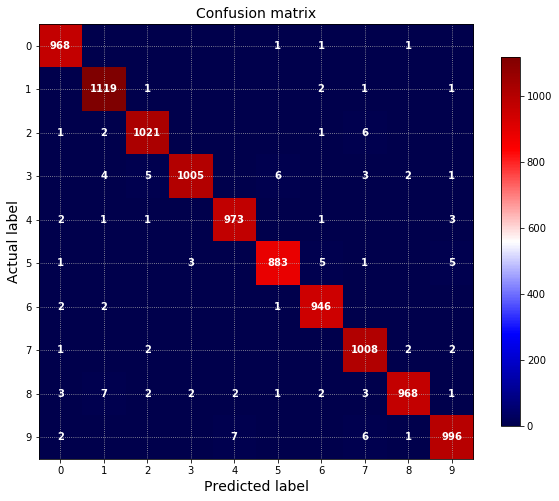

In [9]:
# Example of loading model
def load_checkpoint(path, inference=True):
    checkpoint = torch.load(path)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if inference:
        for parameter in model.parameters():
            parameter.requires_grad = False
    
    return model

model_ = load_checkpoint("model.pt")

device_cpu = torch.device("cpu")
N = 100000

model_.eval()
result_ = torch.argmax(model_.to(device_cpu).forward(test_ds.data[:N].unsqueeze(1).to(device_cpu).to(torch.float)), dim=1).tolist()
plot_confusion_matrix(result_, test_ds.targets[:N].tolist())

## PyTorch

In [31]:
epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_accuracy = 0
    for samples, targets in train_loader:
        optimizer.zero_grad()
        samples, targets = samples.to(device), targets.to(device)
        output = model.forward(samples)
        loss = criterion(output, targets)
        train_loss += loss.item() * len(samples)
        train_accuracy += (torch.argmax(output, dim=1)==targets).sum().item()
        loss.backward()
        optimizer.step()
    else:
        train_loss /= len(train_ds)
        train_accuracy /= len(train_ds)
    
    model.eval()
    test_loss = 0
    test_accuracy = 0
    with torch.no_grad():
        for samples, targets in test_loader:
            samples, targets = samples.to(device), targets.to(device)
            output = model.forward(samples)
            loss = criterion(output, targets)
            test_loss += loss.item() * len(samples)
            test_accuracy += (torch.argmax(output, dim=1)==targets).sum().item()
        else:
            test_loss /= len(test_ds)
            test_accuracy /= len(test_ds)
    
    print(f"Epoch {epoch+1} | train loss: {train_loss:.5f} | train accuracy: {train_accuracy:.5f} | "
          f"test loss: {test_loss:.5f} | test accuracy: {test_accuracy:.5f}")


Epoch 1 | train loss: 0.55754 | train accuracy: 0.99450 | test loss: 1.09897 | test accuracy: 0.98990
Epoch 2 | train loss: 0.48076 | train accuracy: 0.99522 | test loss: 1.02333 | test accuracy: 0.99020
Epoch 3 | train loss: 0.37201 | train accuracy: 0.99627 | test loss: 1.13971 | test accuracy: 0.98950
Epoch 4 | train loss: 0.32356 | train accuracy: 0.99680 | test loss: 1.17111 | test accuracy: 0.98960
Epoch 5 | train loss: 0.28519 | train accuracy: 0.99700 | test loss: 1.16023 | test accuracy: 0.99020


## Skorch

In [10]:
net = NeuralNetClassifier(
    module = ConvClassifier,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    lr=1e-3,
    max_epochs=5,
    batch_size=32,
    train_split=None,
    callbacks=[EpochScoring(scoring=accuracy_score, lower_is_better=False, on_train=True),
               LRScheduler(policy="ExponentialLR", gamma=0.9),
               Checkpoint(monitor=None, f_params='model_skorch.pt')],
    device='cuda'
)

net.fit(X=train_ds, y=None)

  epoch    accuracy_score    train_loss    cp      dur
-------  ----------------  ------------  ----  -------
      1            0.9444        0.1809     +  18.4786
      2            0.9812        0.0615     +  18.2758
      3            0.9875        0.0425     +  18.2819
      4            0.9907        0.0308     +  18.2820
      5            0.9934        0.0216     +  18.3274


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ConvClassifier(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout2d(p=0.2, inplace=False)
    (linear1): Linear(in_features=1600, out_features=64, bias=True)
    (linear2): Linear(in_features=64, out_features=10, bias=True)
  ),
)

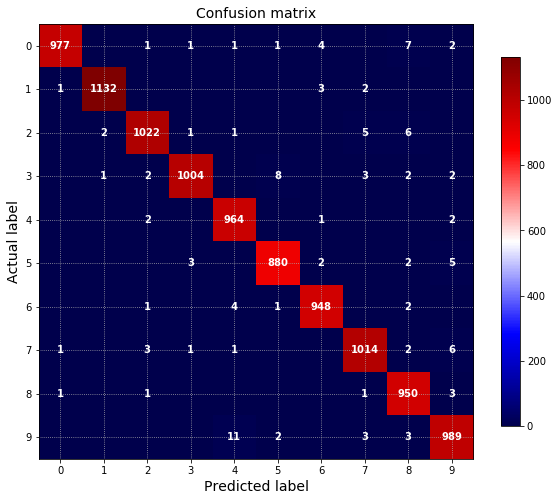

In [13]:
plot_confusion_matrix(net.predict(test_ds), test_ds.targets.tolist())

In [11]:
# Example of loading checkpoint
net_ = NeuralNetClassifier(
    module = ConvClassifier,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    lr=1e-3,
    max_epochs=5,
    batch_size=32,
    train_split=None,
    callbacks=[EpochScoring(scoring=accuracy_score, lower_is_better=False, on_train=True),
               LRScheduler(policy="ExponentialLR", gamma=0.9),
               Checkpoint(monitor=None, f_params='model_skorch.pt')],
    device='cuda'
)

net_.initialize()
net_.load_params(f_params='model_skorch.pt')


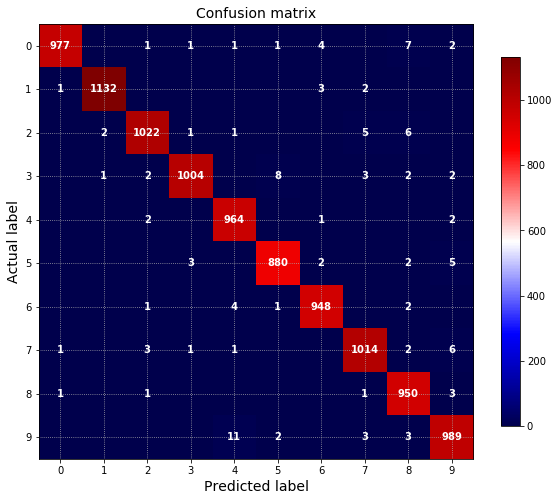

In [12]:
plot_confusion_matrix(net_.predict(test_ds), test_ds.targets.tolist())